# **Import Dataset**

In [ ]:
import pandas as pd # Data manipulation tool

from google.colab import files
uploaded = files.upload()

Saving player_reviews_overall_V2_Build_Model.csv to player_reviews_overall_V2_Build_Model.csv


In [ ]:
# Load the file after uploading
df = pd.read_csv("player_reviews_overall_V2_Build_Model.csv")

In [ ]:
import pandas as pd # Data manipulation tool

# Upload csv file (Visual Studio)
df = pd.read_csv(r"c:\Users\jiunj\Documents\Campus Document\Year 3\FYP\FYP NULL\Dataset\player_reviews_overall_V2_Build_Model.csv")

# **Data Pre-processing**

## Check Column Data Type

In [ ]:
print(df.dtypes)

app_name                  object
review_text               object
review_score               int64
review_length              int64
preprocess_review_text    object
cluster                    int64
dtype: object


## Remove Unwanted Column

In [ ]:
df = df.drop(columns=['app_name'])
df = df.drop(columns=['review_score'])
df = df.drop(columns=['review_length'])
df = df.drop(columns=['preprocess_review_text'])

## Ensure The "review_text" is str Data Type

In [ ]:
df['review_text'] = df['review_text'].astype(str)

## Data Spliting

In [ ]:
#Import Library
from sklearn.model_selection import train_test_split

# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2)

## Random Under Sampling

In [ ]:
# Import Library
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Perform Random Under-sampling on the training set
x_train = train_df.drop(columns=['cluster'])  # Features
y_train = train_df['cluster']  # Target labels

# Initialize RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply random under-sampling to the training data
x_train_resampled, y_train_resampled = under_sampler.fit_resample(x_train, y_train)

# Print class distribution before and after under-sampling
print(f"Original class distribution (train): {Counter(y_train)}")
print(f"Resampled class distribution (train): {Counter(y_train_resampled)}")

# Create a new DataFrame for the resampled training data
train_resampled_df = pd.DataFrame(x_train_resampled, columns=x_train.columns)
train_resampled_df['cluster'] = y_train_resampled

Original class distribution (train): Counter({1: 45833, 7: 6447, 2: 6151, 0: 6112, 3: 5742, 4: 4842, 5: 2747, 6: 2126})
Resampled class distribution (train): Counter({0: 2126, 1: 2126, 2: 2126, 3: 2126, 4: 2126, 5: 2126, 6: 2126, 7: 2126})


## Convert DataFrame to Hugging Face Dataset

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
# Convert DataFrame to Hugging Face dataset
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_resampled_df)
test_dataset = Dataset.from_pandas(test_df)

## Backup The Test & Train Dataset To Train Multiple Different Model

In [ ]:
#Define New Dataset For Backup For To Train Other
train_dataset_backup = train_dataset
test_dataset_backup = test_dataset

# **Build Tiny Bert Model**

## Load Tiny Bert Tokenizer & Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load TinyBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

# Load TinyBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize Text Data

In [ ]:
# Copy The Backup Dataset
train_dataset = train_dataset_backup
test_dataset = test_dataset_backup

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['review_text'], padding="max_length", truncation=True, max_length=150)

# Apply tokenization to train and test datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17008 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

## Prepared Data For Trainning

In [ ]:
# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(["review_text"])  # Remove text column after tokenizing
test_dataset = test_dataset.remove_columns(["review_text"])

# Rename 'cluster' column to 'labels' to match the model's expected format
train_dataset = train_dataset.rename_column("cluster", "labels")
test_dataset = test_dataset.rename_column("cluster", "labels")

In [ ]:
# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

## Train Tiny Bert Model

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    num_train_epochs=6,                # More epochs for better learning
    per_device_train_batch_size=64,    # Balanced batch size based on GPU memory
    per_device_eval_batch_size=128,     # Larger eval batch size for efficiency
    warmup_steps=500,                  # Gradual learning rate increase
    learning_rate=5e-5,                # Adjust the learning rate if necessary
    weight_decay=0.01,                 # Regularization to avoid overfitting
    logging_steps=100,                   # Log less frequently for speed
    evaluation_strategy="epoch",       # Evaluate at the end of each epoch
    save_strategy="epoch",             # Save model after each epoch
    gradient_accumulation_steps=2,     # Gradient accumulation if necessary
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Re-initialize the model each time you train
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=8)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,2.093600,1.989115
2,2.022100,1.809506
3,1.767100,1.397751
4,0.977200,0.876052
5,0.662900,0.649039
6,0.517800,0.604800


TrainOutput(global_step=798, training_loss=1.2364051312133484, metrics={'train_runtime': 48.5356, 'train_samples_per_second': 2102.538, 'train_steps_per_second': 16.442, 'total_flos': 38054678860800.0, 'train_loss': 1.2364051312133484, 'epoch': 6.0})

# **Evaluation Result of Tiny Bert Model**

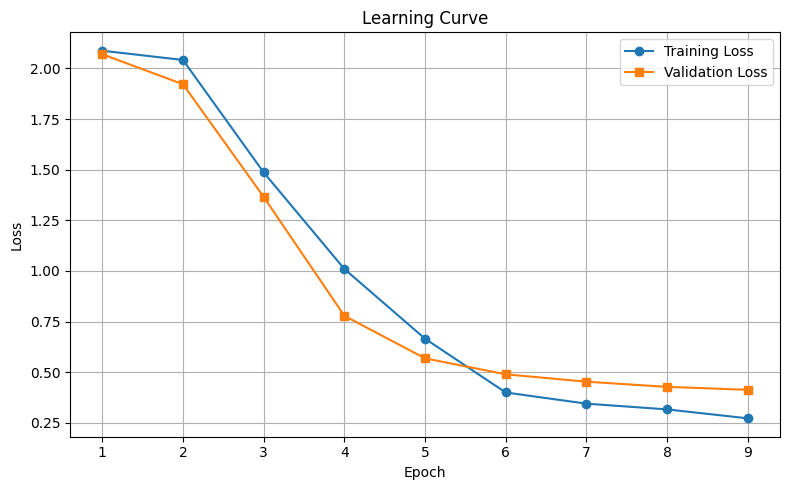

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
training_loss = [2.087800, 2.042000, 1.486600, 1.009800, 0.665300, 0.399600, 0.344300, 0.316000, 0.271800]
validation_loss = [2.070341, 1.922185, 1.365858, 0.778534, 0.568062, 0.489329, 0.452820, 0.427274, 0.412742]

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Tiny Bert)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predicted labels and true labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Print classification report
print("=== Tiny BERT Model ===")
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=2))


=== Tiny BERT Model ===
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1541
           1       0.99      0.87      0.93     11525
           2       0.85      0.96      0.90      1503
           3       0.82      0.96      0.89      1418
           4       0.65      0.93      0.77      1185
           5       0.74      1.00      0.85       665
           6       0.93      1.00      0.96       575
           7       0.84      0.88      0.86      1588

    accuracy                           0.91     20000
   macro avg       0.84      0.95      0.89     20000
weighted avg       0.92      0.91      0.91     20000



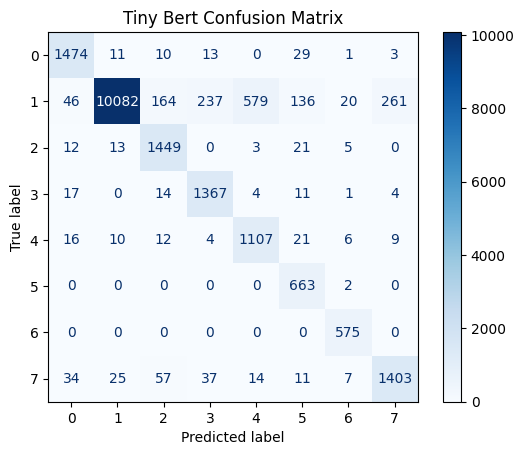

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Tiny Bert Confusion Matrix")
plt.show()  # Display the plot


# **Build Mini Bert Model**

## Load Mini Bert Tokenizer & Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load TinyBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini")

# Load TinyBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-mini", num_labels=8)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize Text Data

In [ ]:
# Copy The Backup Dataset
train_dataset = train_dataset_backup
test_dataset = test_dataset_backup

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['review_text'], padding="max_length", truncation=True, max_length=150)

# Apply tokenization to train and test datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17008 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

## Prepared Data For Trainning

In [ ]:
# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(["review_text"])  # Remove text column after tokenizing
test_dataset = test_dataset.remove_columns(["review_text"])

# Rename 'cluster' column to 'labels' to match the model's expected format
train_dataset = train_dataset.rename_column("cluster", "labels")
test_dataset = test_dataset.rename_column("cluster", "labels")

In [ ]:
# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

## Train Mini Bert Model

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    num_train_epochs=5,                # More epochs for better learning
    per_device_train_batch_size=64,    # Balanced batch size based on GPU memory
    per_device_eval_batch_size=128,     # Larger eval batch size for efficiency
    warmup_steps=500,                  # Gradual learning rate increase
    learning_rate=5e-5,                # Adjust the learning rate if necessary
    weight_decay=0.01,                 # Regularization to avoid overfitting
    logging_steps=100,                   # Log less frequently for speed
    evaluation_strategy="epoch",       # Evaluate at the end of each epoch
    save_strategy="epoch",             # Save model after each epoch
    gradient_accumulation_steps=2,     # Gradient accumulation if necessary
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Re-initialize the model each time you train
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-mini", num_labels=8)
# Initialize Trainer
trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,2.073000,1.954120
2,1.741000,0.883513
3,0.910500,0.465350
4,0.278500,0.373984
5,0.204400,0.314551


TrainOutput(global_step=665, training_loss=0.8688760427604044, metrics={'train_runtime': 159.6793, 'train_samples_per_second': 532.568, 'train_steps_per_second': 4.165, 'total_flos': 247012286400000.0, 'train_loss': 0.8688760427604044, 'epoch': 5.0})

# **Evaluation Result of Mini Bert Model**

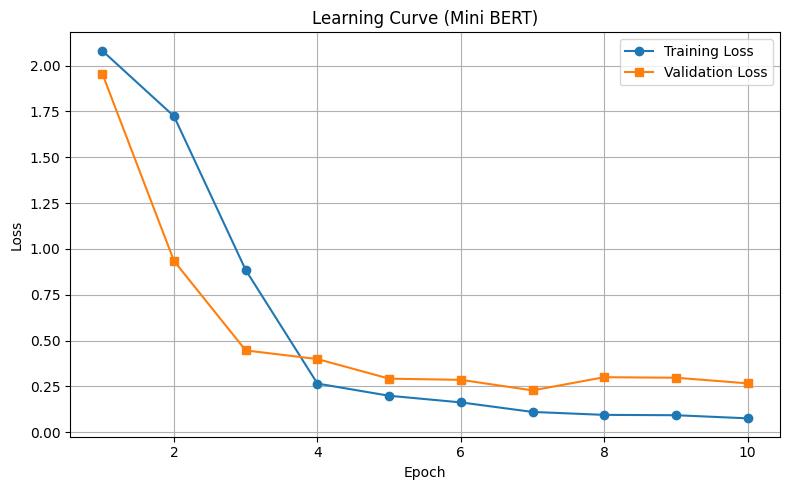

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
training_loss = [2.080700, 1.723200, 0.884600, 0.265600, 0.199300, 0.163000, 0.111000, 0.095000, 0.093100, 0.076100]
validation_loss = [1.955754, 0.933978, 0.446431, 0.399368, 0.292471, 0.286024, 0.228467, 0.300453, 0.297499, 0.266894]

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Mini BERT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predicted labels and true labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Print classification report
print("=== Mini BERT Model ===")
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=2))


=== Mini BERT Model ===
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1541
           1       1.00      0.89      0.94     11525
           2       0.88      0.96      0.92      1503
           3       0.83      0.98      0.90      1418
           4       0.74      0.99      0.85      1185
           5       0.79      1.00      0.88       665
           6       0.95      1.00      0.97       575
           7       0.83      0.91      0.87      1588

    accuracy                           0.92     20000
   macro avg       0.87      0.96      0.91     20000
weighted avg       0.94      0.92      0.93     20000



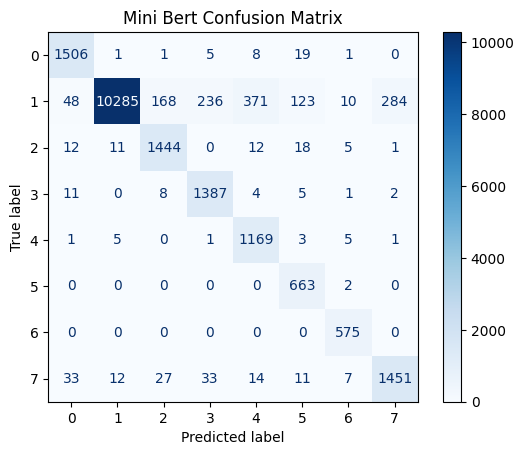

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Mini Bert Confusion Matrix")
plt.show()  # Display the plot


# **Build Small Bert Model**

## Load Small Bert Tokenizer & Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load TinyBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small")

# Load TinyBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-small", num_labels=8)

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize Text Data

In [ ]:
# Copy The Backup Dataset
train_dataset = train_dataset_backup
test_dataset = test_dataset_backup

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['review_text'], padding="max_length", truncation=True, max_length=150)

# Apply tokenization to train and test datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17008 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

## Prepared Data For Trainning

In [ ]:
# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(["review_text"])  # Remove text column after tokenizing
test_dataset = test_dataset.remove_columns(["review_text"])

# Rename 'cluster' column to 'labels' to match the model's expected format
train_dataset = train_dataset.rename_column("cluster", "labels")
test_dataset = test_dataset.rename_column("cluster", "labels")

In [ ]:
# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

## Train Small Bert Model

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    num_train_epochs=3,                # More epochs for better learning
    per_device_train_batch_size=64,    # Balanced batch size based on GPU memory
    per_device_eval_batch_size=128,     # Larger eval batch size for efficiency
    warmup_steps=500,                  # Gradual learning rate increase
    learning_rate=5e-5,                # Adjust the learning rate if necessary
    weight_decay=0.01,                 # Regularization to avoid overfitting
    logging_steps=100,                   # Log less frequently for speed
    evaluation_strategy="epoch",       # Evaluate at the end of each epoch
    save_strategy="epoch",             # Save model after each epoch
    gradient_accumulation_steps=2,     # Gradient accumulation if necessary
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Re-initialize the model each time you train
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-small", num_labels=8)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.984900,1.516819
2,0.946800,0.393519
3,0.270400,0.352601


TrainOutput(global_step=399, training_loss=0.8423673610639453, metrics={'train_runtime': 295.245, 'train_samples_per_second': 172.819, 'train_steps_per_second': 1.351, 'total_flos': 591347138112000.0, 'train_loss': 0.8423673610639453, 'epoch': 3.0})

# **Evaluation Result of Small Bert Model**

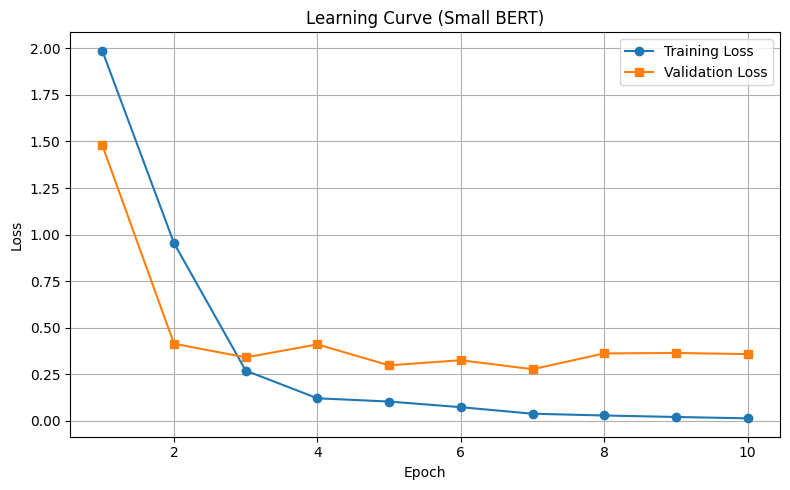

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
training_loss = [1.987100, 0.954200, 0.270300, 0.121700, 0.104200, 0.073900, 0.038900, 0.029400, 0.021400, 0.014100]
validation_loss = [1.480083, 0.414865, 0.341159, 0.410839, 0.298558, 0.326003, 0.277775, 0.362561, 0.364986, 0.358819]

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Small BERT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predicted labels and true labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Print classification report
print("=== Small BERT Model ===")
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=2))


=== Small BERT Model ===
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1541
           1       1.00      0.88      0.94     11525
           2       0.87      0.96      0.91      1503
           3       0.81      0.99      0.89      1418
           4       0.71      0.98      0.82      1185
           5       0.78      0.99      0.88       665
           6       0.95      1.00      0.98       575
           7       0.83      0.91      0.87      1588

    accuracy                           0.92     20000
   macro avg       0.86      0.96      0.90     20000
weighted avg       0.93      0.92      0.92     20000



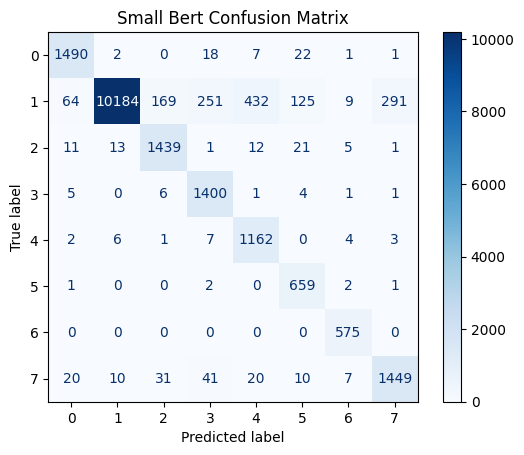

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Small Bert Confusion Matrix")
plt.show()  # Display the plot


# **Build Medium Bert Model**

## Load Medium Bert Tokenizer & Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load TinyBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-medium")

# Load TinyBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-medium", num_labels=8)

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize Text Data

In [ ]:
# Copy The Backup Dataset
train_dataset = train_dataset_backup
test_dataset = test_dataset_backup

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['review_text'], padding="max_length", truncation=True, max_length=150)

# Apply tokenization to train and test datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17008 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

## Prepared Data For Trainning

In [ ]:
# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(["review_text"])  # Remove text column after tokenizing
test_dataset = test_dataset.remove_columns(["review_text"])

# Rename 'cluster' column to 'labels' to match the model's expected format
train_dataset = train_dataset.rename_column("cluster", "labels")
test_dataset = test_dataset.rename_column("cluster", "labels")

In [ ]:
# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

## Train Medium Bert Model

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    num_train_epochs=3,                # More epochs for better learning
    per_device_train_batch_size=64,    # Balanced batch size based on GPU memory
    per_device_eval_batch_size=128,     # Larger eval batch size for efficiency
    warmup_steps=500,                  # Gradual learning rate increase
    learning_rate=5e-5,                # Adjust the learning rate if necessary
    weight_decay=0.01,                 # Regularization to avoid overfitting
    logging_steps=100,                   # Log less frequently for speed
    evaluation_strategy="epoch",       # Evaluate at the end of each epoch
    save_strategy="epoch",             # Save model after each epoch
    gradient_accumulation_steps=2,     # Gradient accumulation if necessary
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Re-initialize the model each time you train
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-medium", num_labels=8)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.940300,1.237482
2,0.707000,0.406620
3,0.215100,0.311923


TrainOutput(global_step=399, training_loss=0.7549614679245722, metrics={'train_runtime': 572.9834, 'train_samples_per_second': 89.05, 'train_steps_per_second': 0.696, 'total_flos': 1170397206489600.0, 'train_loss': 0.7549614679245722, 'epoch': 3.0})

# **Evaluation Result of Medium Bert Model**

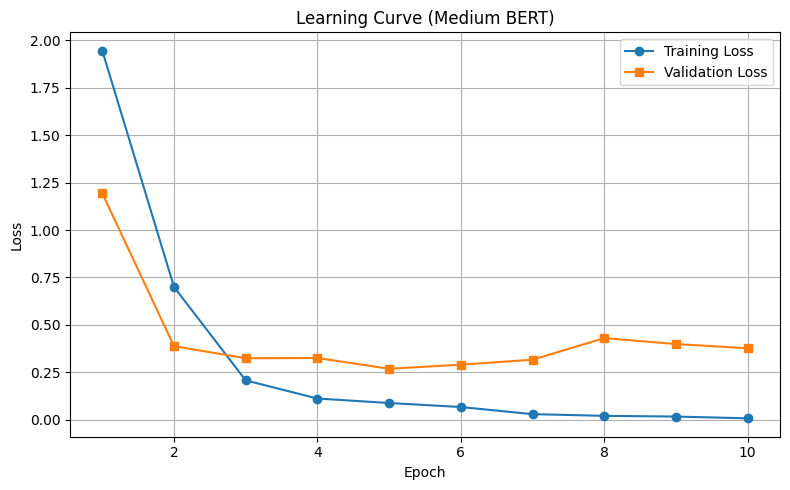

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
training_loss = [1.945100, 0.699700, 0.207200, 0.111700, 0.088000, 0.066800, 0.029400, 0.020300, 0.016600, 0.007200]
validation_loss = [1.193153, 0.387591, 0.324029, 0.325364, 0.268540, 0.290094, 0.316320, 0.430382, 0.398670, 0.376725]

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Medium BERT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predicted labels and true labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Print classification report
print("=== Medium BERT Model ===")
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=2))


=== Medium BERT Model ===
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1541
           1       1.00      0.89      0.94     11525
           2       0.88      0.95      0.91      1503
           3       0.84      0.98      0.90      1418
           4       0.70      0.99      0.82      1185
           5       0.78      0.98      0.87       665
           6       0.95      1.00      0.98       575
           7       0.85      0.94      0.89      1588

    accuracy                           0.92     20000
   macro avg       0.87      0.96      0.91     20000
weighted avg       0.94      0.92      0.92     20000



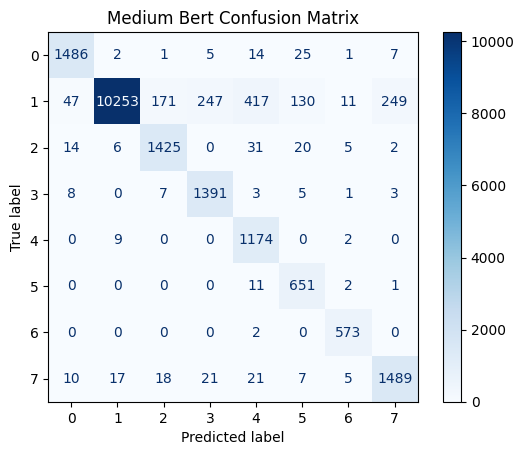

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Medium Bert Confusion Matrix")
plt.show()  # Display the plot
